In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

In [2]:
wine_df = pd.read_csv('clean_data.csv', index_col = 0)

In [3]:
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,density,pH,sulphates,alcohol,wine,best quality
0,2.001480,-0.356675,0.00,0.641854,-2.577022,2.397895,-0.002202,3.51,-0.579818,2.240710,0,1
1,2.054124,-0.127833,0.00,0.955511,-2.322788,3.218876,-0.003205,3.20,-0.385662,2.282382,0,1
2,2.054124,-0.274437,0.04,0.832909,-2.385967,2.708050,-0.003005,3.26,-0.430783,2.282382,0,1
3,1.962001,-1.272966,0.56,0.641854,-2.590267,2.833213,-0.002002,3.16,-0.544727,2.282382,0,1
4,2.001480,-0.356675,0.00,0.641854,-2.577022,2.397895,-0.002202,3.51,-0.579818,2.240710,0,1


In [5]:
wine_df['best quality'].value_counts()

1    6251
0     246
Name: best quality, dtype: int64

In [6]:
feature_cols = list(wine_df.loc[:,['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'wine']])
feature_cols

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'wine']

In [7]:
X = wine_df.drop(['best quality'], axis = 1)
y = wine_df['best quality']
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
pca = PCA(n_components = 0.95)
X = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 40)

In [8]:
print(f"Training dataset shape, X_train: {X_train.shape}, y_train: {y_train.shape}")

Training dataset shape, X_train: (5197, 8), y_train: (5197,)


In [9]:
print(f"Testing dataset shape, X_test: {X_test.shape}, y_test: {y_test.shape}")

Testing dataset shape, X_test: (1300, 8), y_test: (1300,)


In [10]:
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = score(yt, yp)
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

In [11]:
lr = LogisticRegression().fit(X_train,y_train)
lr_pred = lr.predict(X_test)

In [12]:
evaluate_metrics(y_test, lr_pred)

C:\Users\Anchal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.9623076923076923,
 'recall': array([0., 1.]),
 'precision': array([0.        , 0.96230769]),
 'f1score': array([0.        , 0.98079185])}

In [13]:
# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)
lr_l1_preds = lr_l1.predict(X_test)

In [14]:
evaluate_metrics(y_test, lr_l1_preds)

C:\Users\Anchal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.9623076923076923,
 'recall': array([0., 1.]),
 'precision': array([0.        , 0.96230769]),
 'f1score': array([0.        , 0.98079185])}

In [15]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)
lr_l2_preds = lr_l2.predict(X_test)

In [16]:
evaluate_metrics(y_test,lr_l2_preds)

{'accuracy': 0.9615384615384616,
 'recall': array([0.        , 0.99920064]),
 'precision': array([0.        , 0.96227868]),
 'f1score': array([0.        , 0.98039216])}

In [17]:
lr_l1.coef_

array([[-0.10947265,  0.        , -0.8057286 , -3.5088318 , -0.19607415,
        -5.65555093,  0.        , -0.03315843]])

In [18]:
# Extract and sort feature coefficients
def get_feature_coefs(regression_model, label_index, columns):
    coef_dict = {}
    for coef, feat in zip(regression_model.coef_[label_index, :], columns):
        if abs(coef) >= 0.01:
            coef_dict[feat] = coef
    # Sort coefficients
    coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}
    return coef_dict

# Generate bar colors based on if value is negative or positive
def get_bar_colors(values):
    color_vals = []
    for val in values:
        if val <= 0:
            color_vals.append('r')
        else:
            color_vals.append('g')
    return color_vals

# Visualize coefficients
def visualize_coefs(coef_dict):
    features = list(coef_dict.keys())
    values = list(coef_dict.values())
    y_pos = np.arange(len(features))
    color_vals = get_bar_colors(values)
    plt.rcdefaults()
    fig, ax = plt.subplots()
    ax.barh(y_pos, values, align='center', color=color_vals)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    # labels read top-to-bottom
    ax.invert_yaxis()  
    ax.set_xlabel('Feature Coefficients')
    ax.set_title('')
    plt.show()

In [19]:
coef_dict = get_feature_coefs(lr_l1, 0, feature_cols)

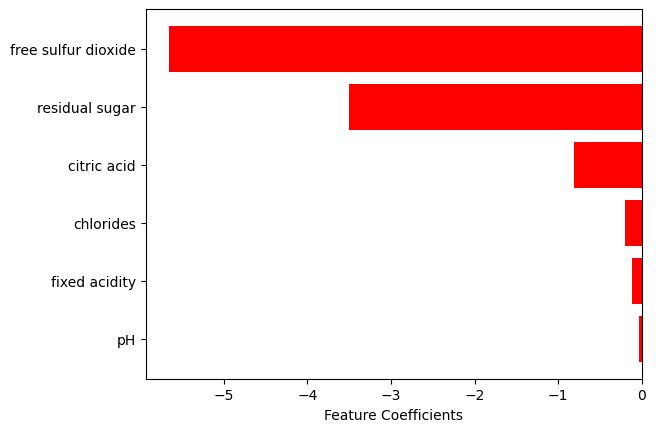

In [20]:
visualize_coefs(coef_dict)

In [21]:
lr_l1_preds

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [22]:
unique, counts = np.unique(lr_l1_preds, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   1 1300]]
